In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from pyquaternion import Quaternion
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance


In [2]:
# Load the Excel file
df_ref = pd.read_excel('Filtered_PCD_Annotations_AB.xlsx')

In [3]:
#selected features is based on the EDA
df_model_x = df_ref[['a_center_x', 'b_center_x',
 'a_center_z',
 'a_length',
 'a_image_coord_y',
 'a_depth',
 'b_depth',
 'a_radar_x']].copy()
df_model_x['delta_center_x'] = df_model_x['b_center_x'] - df_model_x['a_center_x']
df_model_x = df_model_x.drop(columns=['b_center_x'])
print(df_model_x.shape)
df_model_x = df_model_x.drop_duplicates()
print(df_model_x.shape)

(5450, 8)
(5304, 8)


In [4]:
# Prepare the data for modeling x

X = df_model_x[['a_center_x', 'delta_center_x', 'a_center_z',
 'a_length',
 'a_image_coord_y',
 'a_depth',
 'b_depth']]
y = df_model_x['a_radar_x']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
# Define models to evaluate

models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'SVR': SVR()
}

In [6]:
# Evaluate each model
results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    results[name] = {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred)
    }

In [7]:
# Neural Network model

nn_model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(8, activation='relu'),
    Dense(1)
])

nn_model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

nn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0)

y_pred_nn = nn_model.predict(X_test_scaled).flatten()
results['NeuralNet'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_nn)),
    'MAE': mean_absolute_error(y_test, y_pred_nn),
    'R2': r2_score(y_test, y_pred_nn)
}

c:\Users\dilip\anaconda3\envs\radarviz\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [8]:
# Display results

results_df = pd.DataFrame(results).T
print(results_df)

#results_df[['RMSE', 'MAE']].plot(kind='bar', figsize=(10, 6), title='Model Performance')
#plt.ylabel('Error')
#plt.xticks(rotation=45)
#plt.grid(True)
#plt.tight_layout()
#plt.show()

                      RMSE       MAE        R2
LinearRegression  8.181317  5.782329  0.662460
RandomForest      1.615372  0.506731  0.986841
GradientBoosting  1.814399  0.880896  0.983399
SVR               4.872144  1.811862  0.880293
NeuralNet         1.930364  1.087540  0.981209


🔍 Random Forest Performance:
RMSE: 1.5945
MAE: 0.5035
R2: 0.9872


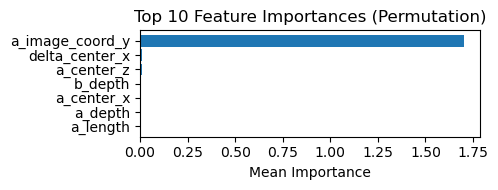

In [9]:
# Further tuning of the best model (Random Forest in this case)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_rf = grid_search.best_estimator_

# Step 2: Predict and evaluate
y_pred_rf = best_rf.predict(X_test_scaled)
results['RandomForest_Tuned'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_rf)),
    'MAE': mean_absolute_error(y_test, y_pred_rf),
    'R2': r2_score(y_test, y_pred_rf)
}

# Print results
print("🔍 Random Forest Performance:")
for metric, value in results['RandomForest_Tuned'].items():
    print(f"{metric}: {value:.4f}")

# Step 3: Residual analysis
#residuals = y_test - y_pred_rf
#plt.figure(figsize=(6, 4))
#plt.hist(residuals, bins=50, color='teal', alpha=0.7)
#plt.title("Residuals Distribution (Random Forest)")
#plt.xlabel("Error")
#plt.ylabel("Frequency")
#plt.tight_layout()
#plt.show()

# Step 4: Permutation importance
perm_importance = permutation_importance(best_rf, X_test_scaled, y_test, n_repeats=10, random_state=42)

# Plot top 10 features
sorted_idx = perm_importance.importances_mean.argsort()[::-1][:10]
plt.figure(figsize=(5, 2))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [X_train.columns[i] for i in sorted_idx])
plt.xlabel("Mean Importance")
plt.title("Top 10 Feature Importances (Permutation)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [10]:
# Prepare the data for Model for y
df_model_y = df_ref[['a_center_x',
 'a_rotation_w',
 'a_rotation_z',
 'a_yaw',
 'a_image_coord_x',
 'a_image_coord_y',
 'a_vehicle_speed', 'b_vehicle_speed', 
 'a_radar_y']].copy()
df_model_y['delta_vehicle_speed'] = df_model_y['b_vehicle_speed'] - df_model_y['a_vehicle_speed']
df_model_y = df_model_y.drop(columns=['a_vehicle_speed', 'b_vehicle_speed'], axis=1)
print(df_model_y.shape)
df_model_y = df_model_y.drop_duplicates()
print(df_model_y.shape)

(5450, 8)
(2624, 8)


In [11]:
# Prepare the data for modeling y

X = df_model_y[['a_center_x',
 'a_rotation_w',
 'a_rotation_z',
 'a_yaw',
 'a_image_coord_x',
 'a_image_coord_y',
 'delta_vehicle_speed']]
y = df_model_y['a_radar_y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
# Define models to evaluate

models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'SVR': SVR()
}

In [13]:
# Evaluate each model

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    results[name] = {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred)
    }

In [14]:
# Neural Network model

nn_model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(8, activation='relu'),
    Dense(1)
])

nn_model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

nn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0)

y_pred_nn = nn_model.predict(X_test_scaled).flatten()
results['NeuralNet'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_nn)),
    'MAE': mean_absolute_error(y_test, y_pred_nn),
    'R2': r2_score(y_test, y_pred_nn)
}

c:\Users\dilip\anaconda3\envs\radarviz\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [15]:
# Display results

results_df = pd.DataFrame(results).T
print(results_df)


                      RMSE       MAE        R2
LinearRegression  3.628652  2.427721  0.769735
RandomForest      0.832630  0.419890  0.987876
GradientBoosting  1.019620  0.654303  0.981819
SVR               2.056020  0.969311  0.926075
NeuralNet         0.744792  0.494205  0.990299


🔍 Random Forest Performance:
RMSE: 0.8000
MAE: 0.4026
R2: 0.9888


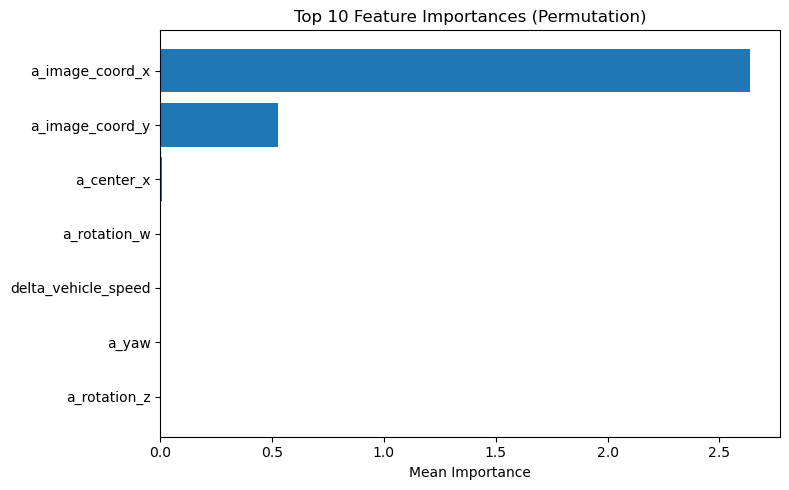

In [16]:
# Fine-tuning of the best model (Random Forest in this case)

# Step 1: Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_rf = grid_search.best_estimator_

# Step 2: Predict and evaluate
y_pred_rf = best_rf.predict(X_test_scaled)
results['RandomForest_Tuned'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_rf)),
    'MAE': mean_absolute_error(y_test, y_pred_rf),
    'R2': r2_score(y_test, y_pred_rf)
}

# Print results
print("🔍 Random Forest Performance:")
for metric, value in results['RandomForest_Tuned'].items():
    print(f"{metric}: {value:.4f}")

# Step 3: Residual analysis
#residuals = y_test - y_pred_rf
#plt.figure(figsize=(6, 4))
#plt.hist(residuals, bins=50, color='teal', alpha=0.7)
#plt.title("Residuals Distribution (Random Forest)")
#plt.xlabel("Error")
#plt.ylabel("Frequency")
#plt.tight_layout()
#plt.show()

# Step 4: Permutation importance
perm_importance = permutation_importance(best_rf, X_test_scaled, y_test, n_repeats=10, random_state=42)

# Plot top 10 features
sorted_idx = perm_importance.importances_mean.argsort()[::-1][:10]
plt.figure(figsize=(8, 5))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [X_train.columns[i] for i in sorted_idx])
plt.xlabel("Mean Importance")
plt.title("Top 10 Feature Importances (Permutation)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()